# Tutorial Distance-Based Selectors

This tutorial demonstrates using distance-based selectors in `selector` package. To easily visualize the data and sampled points, we will use a 2D dataset in this tutorial. However, the same functionality can be applied to higher dimensional datasets.


In [1]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Markdown
from selector.diversity import compute_diversity

from selector.methods.distance import MaxMin, MaxSum, OptiSim, DISE
from selector.methods.partition import Medoid, GridPartition
from selector.diversity import compute_diversity
from selector.methods.similarity import SimilarityIndex, NSimilarity

ModuleNotFoundError: No module named 'selector'

## Utility Function for Plotting Data


In [ ]:
# define a function to make visualization easier


def graph_data(
    data,
    indices=None,
    labels=None,
    reference=False,
    title="",
    xlabel="",
    ylabel="",
    number=False,
    fname=None,
):
    """Graphs the data in a scatter plot.

    Parameters
    ----------
    data : numpy.ndarray of shape (n_samples, 2)
        The original data points to be graphed.
    indices : list of numpy.ndarray, optional
        List of indices array of the data points selected.
    labels : list of str, optional
        List of labels denoting method for selected indices.
    reference : bool, optional
        Whether to highlight the first data point.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label of the x-axis.
    ylabel : str, optional
        The label of the y-axis.
    number : bool, optional
        Whether to label the selected data points with numbers representing the order of selection.
    fname : str, optional
        Filename for saving the figure. If None, figure is shown.
    """
    if data.ndim != 2 or data.shape[1] != 2:
        raise ValueError(f"Expect data to be a 2D array with 2 columns, got {data.shape}.")

    if labels is not None and len(indices) != len(labels):
        raise ValueError(
            f"Expect indices and labels to have the same length, got {len(indices)} and {len(labels)}."
        )

    # Add a title and axis labels
    plt.figure(dpi=100)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # plot original data
    plt.scatter(data[:, 0], data[:, 1], marker="o", facecolors="none", edgecolors="0.75")

    colors = ["skyblue", "r", "b", "k", "g", "orange", "navy", "indigo", "pink", "purple", "yellow"]
    markers = ["o", "x", "*", "_", "|", "s", "p", ">", "<", "^", "v"]
    text_location = [(0.1, 0.1), (-0.1, 0.1)]
    colors_numbers = ["black", "red", "blue", "k", "k", "k", "k", "k", "k", "k", "k"]

    if indices:
        for index, selected_index in enumerate(indices):
            plt.scatter(
                data[selected_index, 0],
                data[selected_index, 1],
                c=colors[index],
                label=labels[index] if labels is not None else None,
                marker=markers[index],
            )
            if number:
                shift_x, shift_y = text_location[index]
                for i, mol_id in enumerate(selected_index):
                    plt.text(
                        data[mol_id, 0] + shift_x,
                        data[mol_id, 1] + shift_y,
                        str(i + 1),
                        c=colors_numbers[index],
                    )
    if reference:
        plt.scatter(data[0, 0], data[0, 1], c="black")
    if labels is not None:
        # plt.legend(loc="upper left", frameon=False)
        plt.legend(loc="best", frameon=False)
    if fname is not None:
        plt.savefig(fname, dpi=500)
    else:
        plt.show()

In [ ]:
# define function to render tables easier


def render_table(data, caption=None, decimals=3):
    """Renders a list of lists in ta markdown table for easy visualization.

    Parameters
    ----------
    data : list of lists
        The data to be rendered in a table, each inner list represents a row with the first row
        being the header.
    caption : str, optional
        The caption of the table.
    decimals : int, optional
        The number of decimal places to round the data to.
    """

    # check all rows have the same number of columns
    if not all(len(row) == len(data[0]) for row in data):
        raise ValueError("Expect all rows to have the same number of columns.")

    if caption is not None:
        # check if caption is a string
        if not isinstance(caption, str):
            raise ValueError("Expect caption to be a string.")
        tmp_output = f"**{caption}**\n\n"

    # get the width of each column (transpose the data list and get the max length of each new row)
    colwidths = [ max(len(str(s)) for s in col) + 2 for col in zip(*data) ]

    # construct the header row
    header = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(data[0], colwidths))} |"
    tmp_output+=header+"\n"

    # construct a separator row
    separator = f"|{'|'.join(['-' * w for w in colwidths])}|"
    tmp_output+=separator+"\n"

    # construct the data rows
    for row in data[1:]:
        # round the data to the specified number of decimal places
        row = [round(s, decimals) if isinstance(s, float) else s for s in row]
        row_str = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(row, colwidths))} |"
        tmp_output+=row_str+"\n"

    return display(Markdown(tmp_output))

## Generating Data

The data should be provided as:

- either an array `X` of shape `(n_samples, n_features)` encoding `n_samples` samples (rows) each in `n_features`-dimensional (columns) feature space,
- or an array `X_dist` of shape `(n_samples, n_samples)` encoding the distance (i.e., dissimilarity) between each pair of `n_samples` sample points.

This data can be loaded from various file formats (e.g., csv, npz, txt, etc.) or generated using various libraries on the fly. In this tutorial, we use [`sklearn.datasets.make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) to generate cluster(s) of `n_samples` points in 2-dimensions (`n-features=2`), so that it can be easily visualized. However, the same functionality can be applied to higher dimensional datasets.


## Selecting from One Cluster


In [ ]:
# generate n_sample data in 2D feature space forming 1 cluster
X, labels = make_blobs(
    n_samples=500,
    n_features=2,
    centers=np.array([[0.0, 0.0]]),
    random_state=42,
)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
print("Cluster size    = ", np.count_nonzero(labels == 0))
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0]
Cluster size    =  500
Shape of the distance array =  (500, 500)


### Example 1: [MaxMin Selector](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxMin)

The `MaxMin` method selects the subset that maximizes the minimum distance to all previously selected points. This method requires the pairwise distance between all points in the dataset, so it is not recommended for large datasets. To select subsets of points, either the dataset's pairwise distance matrix `X_dist` or the feature matrix `X` should be provided. The latter requires specification of `fun_dist(X) -> X_dist` function for computing the pairwise distance between points. This can be a user-defined function or a `sklearn.metrics.pairwise_distances` function, as shown below. Check [MaxMin Documentation](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxMin) for more details.


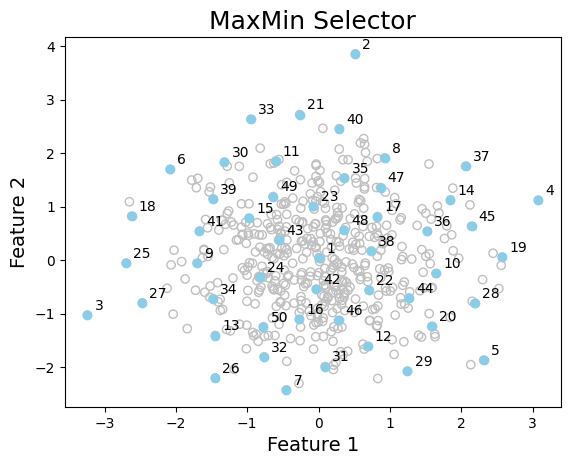

In [ ]:
# select samples using X_dist
selector = MaxMin()
indices_1 = selector.select(X_dist, size=50)

# select samples using X given a distance function (to compute the distance matrix)
selector = MaxMin(fun_dist=lambda x: pairwise_distances(x, metric="euclidean"))
indices_2 = selector.select(X, size=50)

# check if the selected samples are the same
assert indices_1 == indices_2

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_1],
    labels=None,
    title="MaxMin Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

### Example 2: [Directed Sphere Exclusion (DISE) Selector](https://selector.qcdevs.org/dissimilarity.html#selector.distance.DISE)

This selector can be used in a similar fashion, however, there are user-defined parameters that can influence the selected subset.
For example, `ref_index` specifies the index of the reference point which is the first point sampled, and `p` denotes which Minkowski p-norm to use for computing the distance between points. The default value of `p=2` corresponds to the Euclidean distance. Check [DISE Documentation](https://selector.qcdevs.org/dissimilarity.html#selector.distance.DISE) for more details.


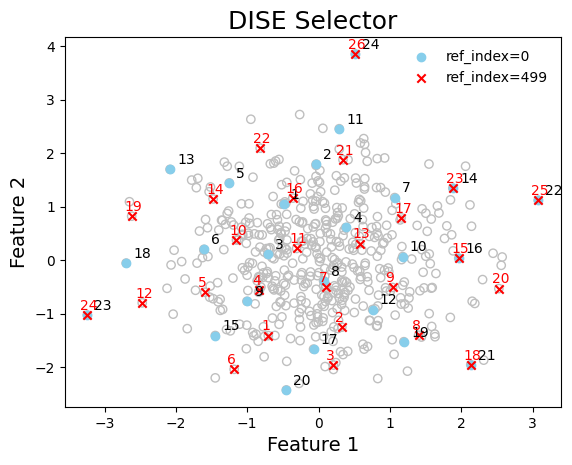

In [ ]:
selector = DISE(ref_index=0, p=2)
indices_1 = selector.select(X_dist, size=25)

selector = DISE(ref_index=499, p=2)
indices_2 = selector.select(X_dist, size=25)

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_1, indices_2],
    labels=["ref_index=0", "ref_index=499"],
    title="DISE Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

## Comparing Multiple Selection Methods (One Cluster)

### Distance-Based Methods

Check Documentation: **[MaxMin](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxMin) | [MaxSum](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxSum) | [OptiSim](https://selector.qcdevs.org/dissimilarity.html#selector.distance.OptiSim) | [DISE](https://selector.qcdevs.org/dissimilarity.html#selector.distance.DISE)**


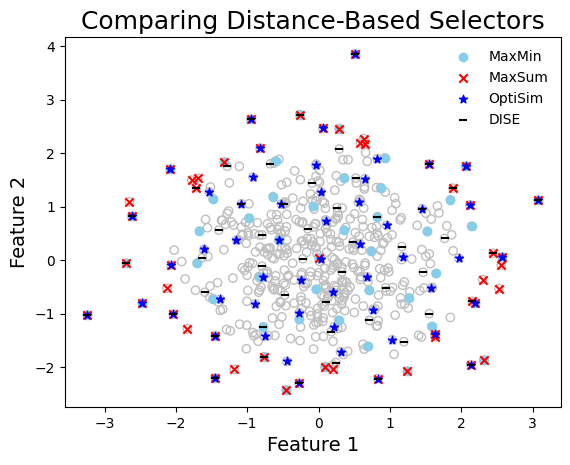

In [ ]:
# select data using distance base methods
# ---------------------------------------
size = 50

selector = MaxMin()
index_maxmin = selector.select(X_dist, size=size)

selector = MaxSum()
index_maxsum = selector.select(X_dist, size=size)

selector = OptiSim(ref_index=0, tol=0.1)
index_optisim = selector.select(X_dist, size=size)

selector = DISE(ref_index=0, p=2.0)
index_dise = selector.select(X, size=size)

graph_data(
    X,
    indices=[index_maxmin, index_maxsum, index_optisim, index_dise],
    labels=["MaxMin", "MaxSum", "OptiSim", "DISE"],
    title="Comparing Distance-Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
    fname="quick_start_compare_distance_methods",
)

### Compute diversity of selected points

The diversity of a set of points can be computed using the `compute_diversity` using any of the several diversity metrics provided in `qc_selector.diversity` module. Here the **log determinant function** (`logdet`)  and the **Wasserstein Distance to Uniform Distribution** (`wdud`) are used to compute the diversity of the selected points. Higher `logdet` and lower `wdud` values indicate higher diversity of the selected points.

In [ ]:
div_measure = ["logdet", "wdud"]
seleced_sets = zip(
        ["MaxMin", "MaxSum", "OptiSim", "DISE"],
        [index_maxmin, index_maxsum, index_optisim, index_dise],
    )

# compute the diversity of the selected sets and render the results in a table
table_data = [[""] + div_measure]
for i in seleced_sets:
    table_data.append([i[0]] + [compute_diversity(X_dist[i[1]], div_type=m) for m in div_measure])

render_table(table_data, caption="Diversity of Selected Sets")

**Diversity of Selected Sets**

|           |        logdet        |         wdud          |
|---------|--------------------|---------------------|
|  MaxMin   |        40.958        |         0.068         |
|  MaxSum   |        33.184        |         0.081         |
|  OptiSim  |        42.466        |         0.076         |
|   DISE    |        40.97         |         0.077         |


### Partition-Based Methods

Check Documentation: **[Medoid](https://selector.qcdevs.org/partition.html#selector.partition.Medoid) | [GridParition](https://selector.qcdevs.org/partition.html#selector.partition.GridPartition)**


/mnt/Data/Work/Ayers/QC-Devs/DiverseSelector/selector/diversity.py:402: UserWarning: The number of molecules should be much larger than the number of features.
  warnings.warn(
/mnt/Data/Work/Ayers/QC-Devs/DiverseSelector/selector/methods/partition.py:124: RuntimeWarning: invalid value encountered in floor_divide
  bin_index = np.floor_divide(X - axis_minimum, bin_length)


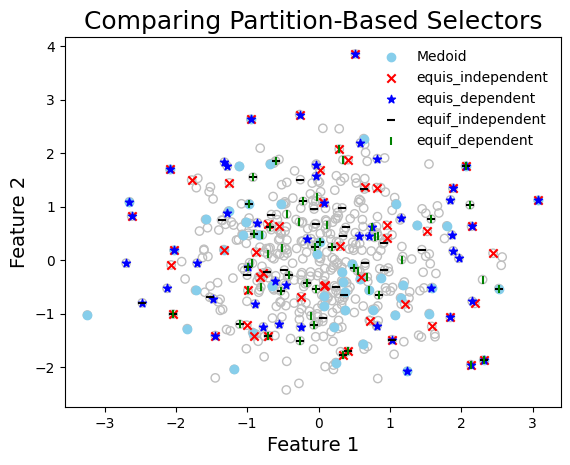

In [ ]:
# select data using grid partitioning methods
# -------------------------------------------
size = 50

selector = Medoid()
selected_medoid = selector.select(X, size=size)

selector = GridPartition(numb_bins_axis=5, grid_method="equisized_independent")
selected_p1 = selector.select(X, size=size)

selector = GridPartition(numb_bins_axis=5, grid_method="equisized_dependent")
selected_p2 = selector.select(X, size=size)

selector = GridPartition(numb_bins_axis=5, grid_method="equifrequent_independent")
selected_p3 = selector.select(X, size=size)

selector = GridPartition(numb_bins_axis=5, grid_method="equifrequent_dependent")
selected_p4 = selector.select(X, size=size)


graph_data(
    X,
    indices=[selected_medoid, selected_p1, selected_p2, selected_p3, selected_p4],
    labels=[
        "Medoid",
        "equis_independent",
        "equis_dependent",
        "equif_independent",
        "equif_dependent",
    ],
    title="Comparing Partition-Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
    fname="quick_start_compare_partition_methods",
)

### Compute diversity of selected points

In [ ]:
div_measure = ["logdet", "wdud"]
set_labels = [
    "Medoid",
    "equis_independent",
    "equis_dependent",
    "equif_independent",
    "equif_dependent",
]
set_indices=[selected_medoid, selected_p1, selected_p2, selected_p3, selected_p4]
seleced_sets = zip(set_labels, set_indices)

# compute the diversity of the selected sets and render the results in a table
table_data = [[""] + div_measure]
for i in seleced_sets:
    table_data.append([i[0]] + [compute_diversity(X_dist[i[1]], div_type=m) for m in div_measure])

render_table(table_data, caption="Diversity of Selected Sets")

**Diversity of Selected Sets**

|                     |        logdet        |         wdud          |
|-------------------|--------------------|---------------------|
|       Medoid        |        38.182        |         0.093         |
|  equis_independent  |        38.449        |         0.079         |
|   equis_dependent   |        37.775        |         0.07          |
|  equif_independent  |        35.816        |         0.102         |
|   equif_dependent   |        34.878        |         0.094         |


### N-Similarity based methods

Check Documentation: <span style="color:red;">**Missing Documentation**</span>

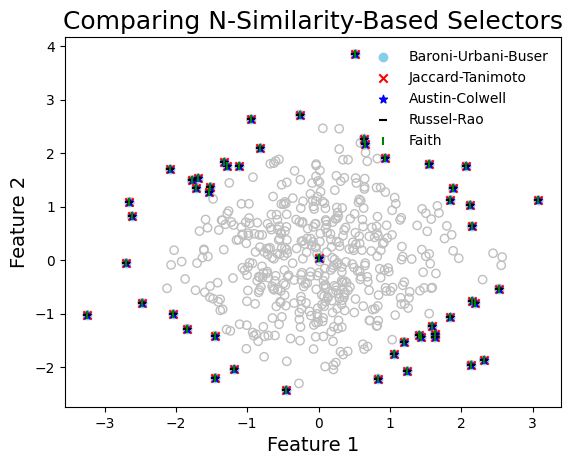

In [ ]:
# select data using n-similarity methods
# -------------------------------------------
size = 50

# Baroni-Urbani-Buser
selector = NSimilarity(similarity_index="BUB", preprocess_data=True)
selected_bub = selector.select(X,size=size)

# Jaccard-Tanimoto
selector = NSimilarity(similarity_index="JT", preprocess_data=True)
selected_jt = selector.select(X, size=size)

# Austin-Colwell
selector = NSimilarity(similarity_index="AC", preprocess_data=True)
selected_ac = selector.select(X, size=size)

# Russel-Rao
selector = NSimilarity(similarity_index="RR", preprocess_data=True)
selected_rr = selector.select(X, size=size)

# Faith
selector = NSimilarity(similarity_index="Fai", preprocess_data=True)
selected_fai = selector.select(X, size=size)


graph_data(
    X,
    indices=[selected_bub, selected_jt, selected_ac, selected_rr, selected_fai],
    labels=[
        "Baroni-Urbani-Buser",
        "Jaccard-Tanimoto",
        "Austin-Colwell",
        "Russel-Rao",
        "Faith",
    ],
    title="Comparing N-Similarity-Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
    fname="quick_start_compare_partition_methods",
)

### Compute diversity of selected points

The similarity of a set of points can be computed using the `SimilarityIndex` class and an appropriate similarity index (Check Documentation: <span style="color:red;">**Missing Documentation**</span>). The diversity of the set can then be computed as `1 - similarity_index`.

In [ ]:
set_indices=[selected_bub, selected_jt, selected_ac, selected_rr, selected_fai]
sim_idx_list = ["BUB", "JT", "AC", "RR", "Fai"]
set_labels = ["Baroni-Urbani-Buser", "Jaccard-Tanimoto", "Austin-Colwell", "Russel-Rao", "Faith"]
selected_sets = zip(set_labels, sim_idx_list, set_indices)

scaled_data = NSimilarity()._scale_data(X)

# The similarity of a set of data points
table_data = [[""] + sim_idx_list]
for i in selected_sets:
    table_data.append([i[0]] + [1 - SimilarityIndex(si)(scaled_data[i[2]]) for si in sim_idx_list])

caption = "Diversity of Selected Sets: row = selected set, column = 1 - similarity index"
render_table(table_data, caption=caption)

print("The selected sets coincide for all similarity indices.\n"
      "This is due to the fact that the data has low dimensionality\n")

**Similarity of Selected Sets: row = selected set, column = 1 - similarity index**

|                       |          BUB          |          JT           |          AC           |          RR           |          Fai          |
|---------------------|---------------------|---------------------|---------------------|---------------------|---------------------|
|  Baroni-Urbani-Buser  |         0.442         |         0.442         |         0.463         |         0.442         |         0.442         |
|   Jaccard-Tanimoto    |         0.442         |         0.442         |         0.463         |         0.442         |         0.442         |
|    Austin-Colwell     |         0.442         |         0.442         |         0.463         |         0.442         |         0.442         |
|      Russel-Rao       |         0.442         |         0.442         |         0.463         |         0.442         |         0.442         |
|         Faith         |         0.442         |         0.442         |         0.463         |         0.442         |         0.442         |


The selected sets coincide for all similarity indices.
This is due to the fact that the data has low dimensionality



## Comparing Multiple Selection Methods (Multiple Clusters)

Each cluster is treated independently, and if possible, equal number of samples are selected from each cluster. However, if a cluster is underpopulated, then all points from that cluster are selected. This is to ensure that the selected subset is representative of the entire dataset.


In [ ]:
# generate n_sample data in 2D feature space forming 3 clusters
X, labels = make_blobs(n_samples=500, n_features=2, centers=2, random_state=42)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
size_0, size_1 = np.count_nonzero(labels == 0), np.count_nonzero(labels == 1)
print("Cluster sizes = ", size_0, size_1)
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0 1]
Cluster sizes =  250 250
Shape of the distance array =  (500, 500)


### Distance-Based Methods

To select from multiple clusters provide the `labels` argument to the `select` method.
Check Documentation: **[MaxMin](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxMin) | [MaxSum](https://selector.qcdevs.org/dissimilarity.html#selector.distance.MaxSum) | [OptiSim](https://selector.qcdevs.org/dissimilarity.html#selector.distance.OptiSim) | [DISE](https://selector.qcdevs.org/dissimilarity.html#selector.distance.DISE)**


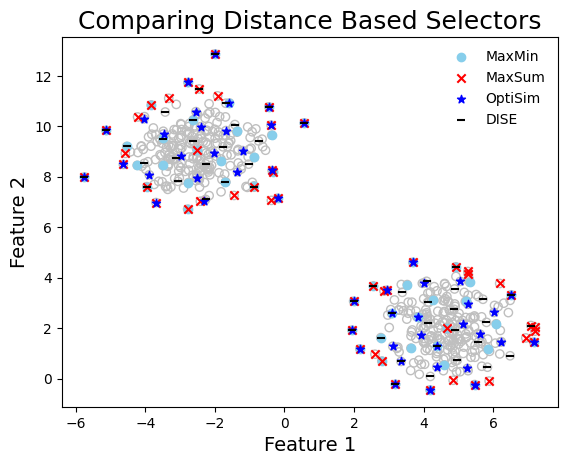

In [ ]:
# select data using distance base methods with labels
# ---------------------------------------------------
size = 50

selector = MaxMin()
index_maxmin = selector.select(X_dist, size=size, labels=labels)

selector = MaxSum()
index_maxsum = selector.select(X_dist, size=size, labels=labels)

selector = OptiSim(ref_index=0, tol=0.1)
index_optisim = selector.select(X_dist, size=size, labels=labels)

selector = DISE(ref_index=0, p=2.0)
index_dise = selector.select(X, size=size, labels=labels)

graph_data(
    X,
    indices=[index_maxmin, index_maxsum, index_optisim, index_dise],
    labels=["MaxMin", "MaxSum", "OptiSim", "DISE"],
    title="Comparing Distance Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
)

### Partition-Based Methods

To select from multiple clusters provide the `labels` argument to the `select` method.
Check Documentation: **[Medoid](https://selector.qcdevs.org/partition.html#selector.partition.Medoid) | [GridParition](https://selector.qcdevs.org/partition.html#selector.partition.GridPartition)**


/mnt/Data/Work/Ayers/QC-Devs/DiverseSelector/selector/diversity.py:402: UserWarning: The number of molecules should be much larger than the number of features.
  warnings.warn(
/mnt/Data/Work/Ayers/QC-Devs/DiverseSelector/selector/methods/partition.py:124: RuntimeWarning: invalid value encountered in floor_divide
  bin_index = np.floor_divide(X - axis_minimum, bin_length)


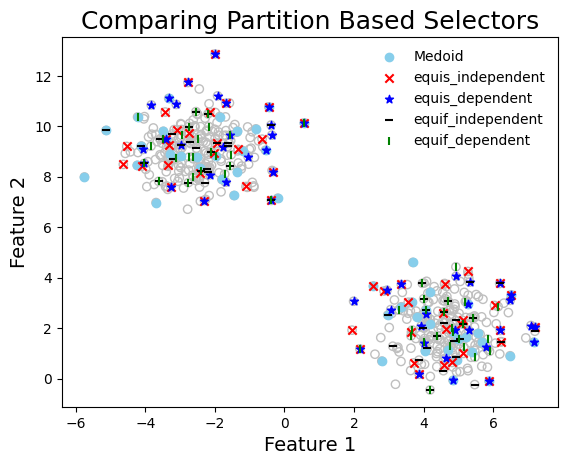

In [ ]:
# select data using grid partitioning methods
# -------------------------------------------
size = 50

selector = Medoid()
selected_medoid = selector.select(X, size=size, labels=labels)

selector = GridPartition(5, "equisized_independent")
selected_p1 = selector.select(X, size=size, labels=labels)

selector = GridPartition(5, "equisized_dependent")
selected_p2 = selector.select(X, size=size, labels=labels)

selector = GridPartition(5, "equifrequent_independent")
selected_p3 = selector.select(X, size=size, labels=labels)

selector = GridPartition(5, "equifrequent_dependent")
selected_p4 = selector.select(X, size=size, labels=labels)


graph_data(
    X,
    indices=[selected_medoid, selected_p1, selected_p2, selected_p3, selected_p4],
    labels=[
        "Medoid",
        "equis_independent",
        "equis_dependent",
        "equif_independent",
        "equif_dependent",
    ],
    title="Comparing Partition Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
)

### N-Similarity based methods

Check Documentation: <span style="color:red;">**Missing Documentation**</span>

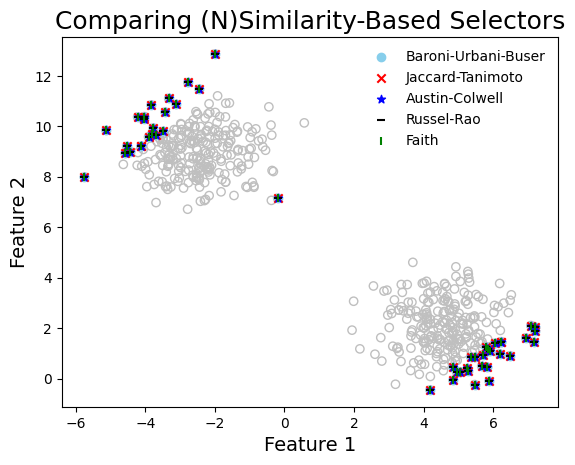

In [ ]:
# select data using n-similarity methods
# -------------------------------------------
size = 50

# Baroni-Urbani-Buser
selector = NSimilarity(similarity_index="BUB", preprocess_data=True, inv)
selected_bub = selector.select(X,size=size)

# Jaccard-Tanimoto
selector = NSimilarity(similarity_index="JT", preprocess_data=True)
selected_jt = selector.select(X, size=size)

# Austin-Colwell
selector = NSimilarity(similarity_index="AC", preprocess_data=True)
selected_ac = selector.select(X, size=size)

# Russel-Rao
selector = NSimilarity(similarity_index="RR", preprocess_data=True)
selected_rr = selector.select(X, size=size)

# Faith
selector = NSimilarity(similarity_index="Fai", preprocess_data=True)
selected_fai = selector.select(X, size=size)


graph_data(
    X,
    indices=[selected_bub, selected_jt, selected_ac, selected_rr, selected_fai],
    labels=[
        "Baroni-Urbani-Buser",
        "Jaccard-Tanimoto",
        "Austin-Colwell",
        "Russel-Rao",
        "Faith",
    ],
    title="Comparing (N)Similarity-Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
    fname="quick_start_compare_partition_methods",
)